In [1]:
import joblib
import pandas as pd
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn

import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

%matplotlib inline
output_notebook()

tweets = pd.read_csv('../tweets/tweets_clean.csv',
                     header=0,
                     parse_dates=['date'])
tweets.dropna(subset=['lemmas'], inplace=True)
tweets.reset_index(drop=True, inplace=True)

doc_topics = pd.read_csv('../scripts/topic_modeling_objects/topics_per_doc_LDA.csv',
                         header=0)
tweets['topic'] = doc_topics['dominant_topic']

# Load vectorizer
with open('../scripts/topic_modeling_objects/sklearn_vect.joblib', 'rb') as f:
    cv = joblib.load(f)

# Load term frequency matrix
with open('../scripts/topic_modeling_objects/sklearn_CV.joblib', 'rb') as f:
    tf = joblib.load(f)

# Load feature names
with open('../scripts/topic_modeling_objects/sklearn_feature_names.joblib', 'rb') as f:
    tf_names = joblib.load(f)

# Load fitted LDA model
with open('../scripts/topic_modeling_objects/sklearn_LDA_model.joblib', 'rb') as f:
    lda_model = joblib.load(f)
    
lda_W = lda_model.transform(tf)

Loading BokehJS ...

In [2]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, cv, mds='tsne')
panel

D:\jmelt\Documents\UNCC\ITIS4510\Russian_Tweets\venv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      -79.586159  735.812012       1        1  7.529637
2      530.875549  372.021790       2        1  7.453647
9      250.989868  586.880432       3        1  7.378792
8      160.698135  -65.314659       4        1  7.316427
11     495.827393   26.663721       5        1  7.226811
3      -59.436409  423.964996       6        1  7.089555
4      226.612396  246.723358       7        1  7.031905
6     -172.836365 -111.555473       8        1  6.576050
1     -363.451538  208.240631       9        1  6.255124
10    -524.962402  -61.302818      10        1  6.225827
14    -401.711182  519.973145      11        1  6.177583
5     -317.285156 -388.780853      12        1  6.162971
7      -58.743275  144.067169      13        1  6.133565
12     388.016296 -303.370972      14        1  5.779927
13      45.037899 -386.081116      15        1  5.662181, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
895   Default   8790.000000         get   8790.000000  30.0000  30.0000
2262  Default  31217.000000       trump  31217.000000  29.0000  29.0000
913   Default   6454.000000          go   6454.000000  28.0000  28.0000
1508  Default   8451.000000       obama   8451.000000  27.0000  27.0000
1896  Default   8081.000000         say   8081.000000  26.0000  26.0000
1317  Default   6117.000000        make   6117.000000  25.0000  25.0000
1469  Default   5616.000000         new   5616.000000  24.0000  24.0000
405   Default   7665.000000     clinton   7665.000000  23.0000  23.0000
1470  Default   4904.000000        news   4904.000000  22.0000  22.0000
2334  Default   4700.000000        vote   4700.000000  21.0000  21.0000
920   Default   4914.000000        good   4914.000000  20.0000  20.0000
1205  Default   4462.000000        know   4462.000000  19.0000  19.0000
994   Default   5150.000000     hillary   5150.000000  18.0000  18.0000
81    Default   4038.000000    american   4038.000000  17.0000  17.0000
1638  Default   4233.000000     politic   4233.000000  16.0000  16.0000
2140  Default   3971.000000        take   3971.000000  15.0000  15.0000
79    Default   4135.000000     america   4135.000000  14.0000  14.0000
546   Default   4056.000000         day   4056.000000  13.0000  13.0000
1675  Default   3887.000000   president   3887.000000  12.0000  12.0000
2150  Default   3917.000000        tcot   3917.000000  11.0000  11.0000
234   Default   3853.000000       black   3853.000000  10.0000  10.0000
2348  Default   4578.000000        want   4578.000000   9.0000   9.0000
1926  Default   3762.000000         see   3762.000000   8.0000   8.0000
1326  Default   3548.000000         man   3548.000000   7.0000   7.0000
2192  Default   3746.000000       think   3746.000000   6.0000   6.0000
695   Default   3232.000000    election   3232.000000   5.0000   5.0000
1300  Default   3494.000000        love   3494.000000   4.0000   4.0000
2421  Default   3492.000000       would   3492.000000   3.0000   3.0000
2429  Default   3504.000000        year   3504.000000   2.0000   2.0000
310   Default   3485.000000        call   3485.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
695   Topic15   3231.585249    election   3232.516666   2.8711  -2.9487
424   Topic15   2772.958534        come   2773.889951   2.8710  -3.1018
1279  Topic15   2237.680703        live   2238.612121   2.8709  -3.3163
2273  Topic15   2187.324031         try   2188.255449   2.8709  -3.3390
2142  Topic15   1881.022826        talk   1881.954244   2.8709  -3.4899
1292  Topic15   1812.630988        lose   1813.562405   2.8708  -3.5269
1570  Topic15   1585.612844       party   1586.544262   2.8708  -3.6607
1763  Topic15   1370.497172        read   1371.428589   2.8707  -3.8065
2047  Topic15   1315.927218      spe

In [4]:
# Construct k-means clusters
clusters = KMeans(n_clusters=15,
                  random_state=100).fit_predict(lda_W)
colors = ['#E53935', '#0288D1', '#8E24AA', '#00796B', '#689F38',
          '#D81B60', '#5E35B1', '#AFB42B', '#FBC02D', '#90A4AE',
          '#F57C00', '#1976D2', '#3949AB', '#0097A7', '#8D6E63']

# Build Singluar Value Decomposition (SVD) model
svd_model = TruncatedSVD(n_components=2)
lda_output_svd = svd_model.fit_transform(lda_W)

x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

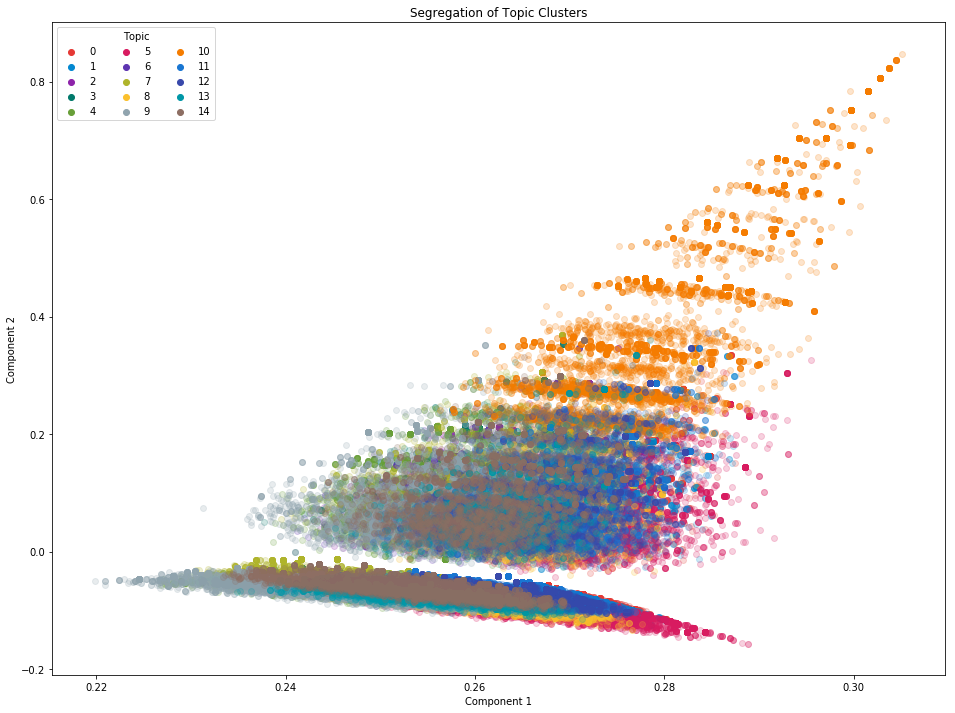

In [9]:
fig = plt.figure(figsize=(16, 12))
for topic, color in zip(np.unique(clusters), colors):
    i = np.where(clusters == topic)
    plt.scatter(x[i], y[i], c=color, label=topic, alpha=0.2)

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Segregation of Topic Clusters')
leg = plt.legend(title='Topic', loc='best', ncol=3)

for lh in leg.legendHandles:
    lh.set_alpha(1)

fig.savefig('../visuals/LDA_topic_clusters_2D.png')
plt.show()

In [3]:
topics_per_month = tweets.groupby([tweets.date.dt.year, tweets.date.dt.month, tweets.topic]).size().to_frame('counts')
topics_per_month.index.rename(['year', 'month'], level=[0, 1], inplace=True)

topics_per_month = topics_per_month.unstack(level=2, fill_value=0)

# # Collapse index back into a single date
topics_per_month.columns = topics_per_month.columns.droplevel(0)
topics_per_month.reset_index(inplace=True)
topics_per_month['date'] = pd.to_datetime(dict(year=topics_per_month.year,
                                               month=topics_per_month.month,
                                               day=[1] * len(topics_per_month)))
topics_per_month.drop(['year', 'month'], axis=1, inplace=True)
topics_per_month.columns = topics_per_month.columns.values.astype('str')

In [4]:
def monthly_topics(tweets_df):
    topics = [str(i) for i in range(15)]

    palette = ['#E53935', '#0288D1', '#8E24AA', '#00796B', '#689F38',
               '#D81B60', '#5E35B1', '#AFB42B', '#FBC02D', '#90A4AE',
               '#F57C00', '#1976D2', '#3949AB', '#0097A7', '#8D6E63']

    src = ColumnDataSource(tweets_df.to_dict('list'))

    p = figure(width=1200, height=800,
               x_axis_type='datetime',
               x_axis_label='Date',
               y_axis_label='Number of tweets',
               title='Tweets per month')

    renderers = p.vbar_stack(topics, x='date', color=palette,
                             width=3.6e8 * 5,
                             legend=["Topic " + x for x in topics],
                             source=src)

    legend = p.legend[0]
    p.legend[0].plot = None
    p.add_layout(legend, 'right')

    for r in renderers:
        topic = r.name
        hover = HoverTool(tooltips=[('Date', '@date{%B-%Y}'),
                                    ('Topic {}'.format(topic), '@$name')],
                          formatters={'date': 'datetime'},
                          mode='mouse',
                          renderers=[r])
        p.add_tools(hover)

    p.xgrid.grid_line_color = None

    return p

In [5]:
topics_plot = monthly_topics(topics_per_month)
show(topics_plot)

In [6]:
monthly_props = topics_per_month.drop('date', axis=1).apply(lambda x: 100. * x / x.sum(), axis=1)
monthly_props['date'] = topics_per_month['date']

In [7]:
topics_prop_plot = monthly_topics(monthly_props)
show(topics_prop_plot)